In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -qr yolov5/requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 10555, done.
remote: Total 10555 (delta 0), reused 0 (delta 0), pack-reused 10555
Receiving objects: 100% (10555/10555), 10.74 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (7292/7292), done.
     |████████████████████████████████| 596 kB 3.9 MB/s 


In [3]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Annotation Read and Handling

- https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [8]:
!unzip "/content/drive/MyDrive/archive.zip" ### todo: change the path

Archive:  /content/drive/MyDrive/archive.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotati

In [24]:
path_an = "/content/drive/MyDrive/21. 20220117_DAY20/archive/annotations" ### todo: change the path

In [25]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in tqdm(glob.glob(path_an+"/*.xml")):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name'].append(name)
                    dataset['width'].append(width)
                    dataset['height'].append(height) 
                    dataset['file'].append(anno.split('/')[-1][0:-4])
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin'].append(xmin)
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin'].append(ymin)                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax'].append(xmax)                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax'].append(ymax)

    #break

100%|██████████| 853/853 [00:00<00:00, 999.31it/s] 


In [ ]:
dataset

In [26]:
df=pd.DataFrame(dataset)

name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

df['class'] = df['name'].map(name_dict)

df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss108,with_mask,400,225,155,29,180,51,0
1,maksssksksss108,with_mask,400,225,206,35,228,58,0
2,maksssksksss108,with_mask,400,225,332,67,346,81,0
3,maksssksksss108,with_mask,400,225,362,68,376,82,0
4,maksssksksss108,without_mask,400,225,267,72,278,83,2


In [30]:
len(df)

4072

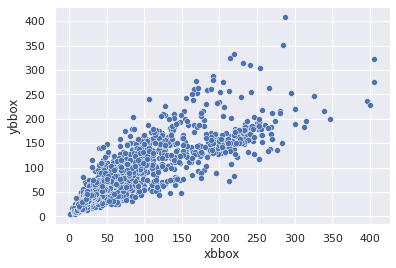

In [27]:
H, W = 640, 480

df['xmax'] = (H/df['width'])*df['xmax']
df['ymax'] = (W/df['height'])*df['ymax']
df['xmin'] = (H/df['width'])*df['xmin']
df['ymin'] = (W/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')
df['x_center'] = (df['xmax']+df['xmin'])/(2*H)
df['y_center'] = (df['ymax']+df['ymin'])/(2*W)
df['box_height'] = (df['xmax']-df['xmin'])/H
df['box_width'] = (df['ymax']-df['ymin'])/W
df['xbbox'] = df['xmax']-df['xmin']
df['ybbox'] = df['ymax']-df['ymin']

sns.set()
sns.scatterplot(x='xbbox',  y='ybbox', data=df)
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file        4072 non-null   object 
 1   name        4072 non-null   object 
 2   width       4072 non-null   int64  
 3   height      4072 non-null   int64  
 4   xmin        4072 non-null   int64  
 5   ymin        4072 non-null   int64  
 6   xmax        4072 non-null   int64  
 7   ymax        4072 non-null   int64  
 8   class       4072 non-null   int64  
 9   x_center    4072 non-null   float64
 10  y_center    4072 non-null   float64
 11  box_height  4072 non-null   float64
 12  box_width   4072 non-null   float64
 13  xbbox       4072 non-null   int64  
 14  ybbox       4072 non-null   int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 477.3+ KB


# Split Data into Train, Validation, and Test.

In [36]:
image_dir = '/content/drive/MyDrive/21. 20220117_DAY20/archive/images'
fileNames = os.listdir(image_dir)
len(fileNames)

853

In [37]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [39]:
os.makedirs('/content/yolov5/data/train/images', exist_ok = True)
os.makedirs('/content/yolov5/data/train/labels', exist_ok = True)
os.makedirs('/content/yolov5/data/test/images', exist_ok = True)
os.makedirs('/content/yolov5/data/test/labels', exist_ok = True)
os.makedirs('/content/yolov5/data/val/images', exist_ok = True)
os.makedirs('/content/yolov5/data/val/labels', exist_ok = True)

In [44]:
from PIL import Image

def copyImages(imageList, folder_Name, height=640, width=480, from_dir='/content/images', to_dir='/content/yolov5/data'):
    for image in tqdm(imageList):
        img = Image.open(os.path.join(from_dir,image))
        img1 = img.resize((height, width))
        img1.save(os.path.join(to_dir,folder_Name,"images",image))

In [45]:
copyImages(train, "train") #### todo: set the from_dir parameter
copyImages(val, "val")  #### todo: set the from_dir parameter
copyImages(test, "test") #### todo: set the from_dir parameter

100%|██████████| 25/25 [00:04<00:00,  6.23it/s]


In [46]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width,xbbox,ybbox
0,maksssksksss108,with_mask,400,225,248,61,288,108,0,0.418750,0.176042,0.062500,0.097917,40,47
1,maksssksksss108,with_mask,400,225,329,74,364,123,0,0.541406,0.205208,0.054688,0.102083,35,49
2,maksssksksss108,with_mask,400,225,531,142,553,172,0,0.846875,0.327083,0.034375,0.062500,22,30
3,maksssksksss108,with_mask,400,225,579,145,601,174,0,0.921875,0.332292,0.034375,0.060417,22,29
4,maksssksksss108,without_mask,400,225,427,153,444,177,2,0.680469,0.343750,0.026562,0.050000,17,24


In [47]:
df = df.astype('string')

In [48]:
def create_labels(image_list, data_name, data_root = "/content/yolov5/data"):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in tqdm(fileNames):
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(os.path.join(data_root,data_name,"labels",name+".txt"), "w") as file:
            file.write(text)

In [49]:
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

100%|██████████| 25/25 [00:00<00:00, 411.42it/s]


# Configuration Model

In [50]:
%cd yolov5

/content/yolov5


In [51]:
from IPython.core.display import Image, Video, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-192-g436ffc4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 43.2/166.8 GB disk)


In [52]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [53]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [54]:
%cat data/data.yaml


train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [55]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [56]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [57]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-192-g436ffc4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0

In [58]:
print("Runtime =",end-start)


Runtime = 0:37:33.357785


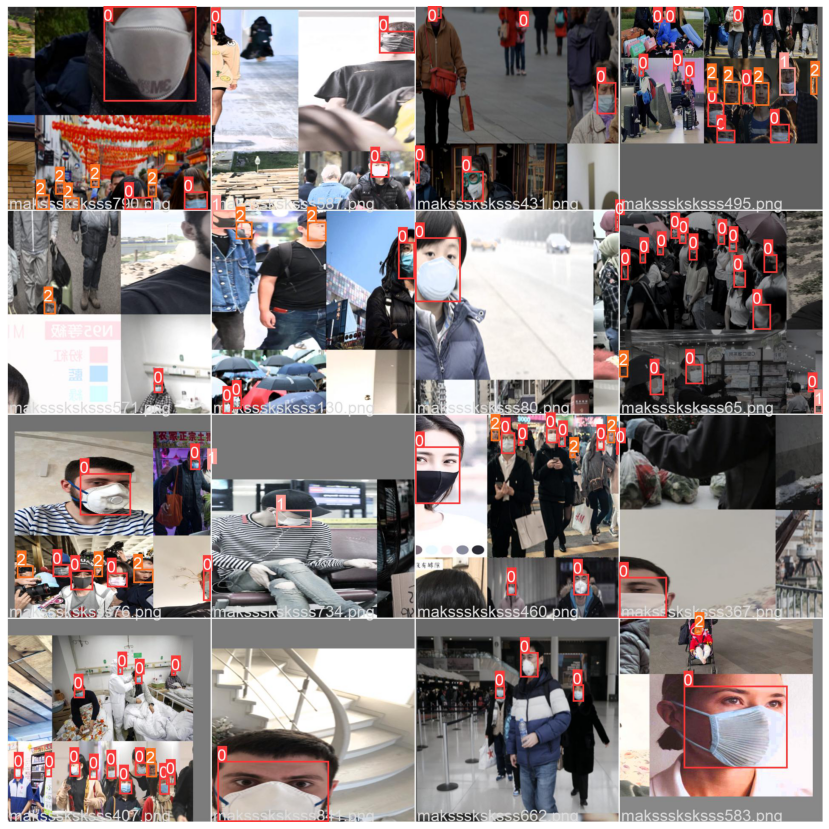

In [64]:
img = plt.imread('/content/yolov5/runs/train/yolov5s_results/train_batch1.jpg')  # todo: fill the path
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Evaluation Model

In [69]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-192-g436ffc4 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/25 /content/yolov5/data/test/images/maksssksksss1.png: 480x640 6 with_masks, 1 without_mask, Done. (0.010s)
image 2/25 /content/yolov5/data/test/images/maksssksksss119.png: 480x640 5 with_masks, 2 without_masks, Done. (0.008s)
image 3/25 /content/yolov5/data/test/images/maksssksksss128.png: 480x640 1 without_mask, Done. (0.008s)
image

In [70]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [77]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('/content/yolov5/runs/detect/expTestImage3/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


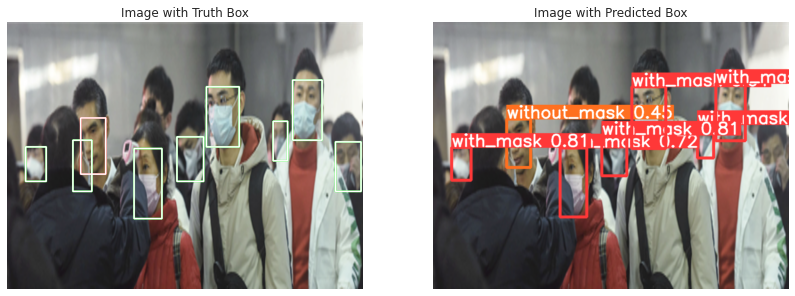

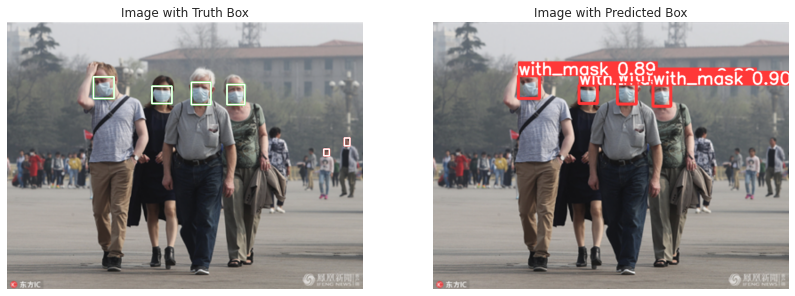

In [78]:
show_image("maksssksksss1")  # todo: set the input
show_image("maksssksksss381")  # todo: set the input
plt.show()